In [1]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()
x_train = x_train[y_train.squeeze() == 1]
x_train = (x_train / 127.5) - 1.0

In [3]:
input_image=32
batch_size=128
timesteps=16  #how many time for noisy image to get inot clear
time_bar=1 - np.linspace(0, 1.0, timesteps + 1)

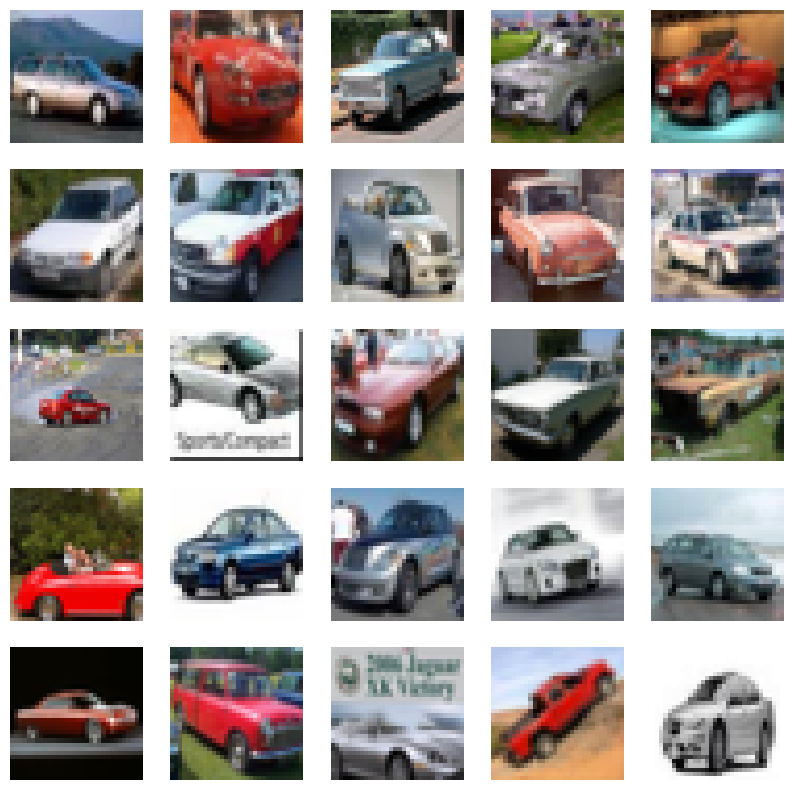

In [4]:
def cvImage(img):
    img=img-img.min()
    img=(img/img.max())
    return img.astype(np.float32)
def show_examples(x):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        img=cvImage(x[i])
        plt.imshow(img)
        plt.axis('off')
show_examples(x_train)        

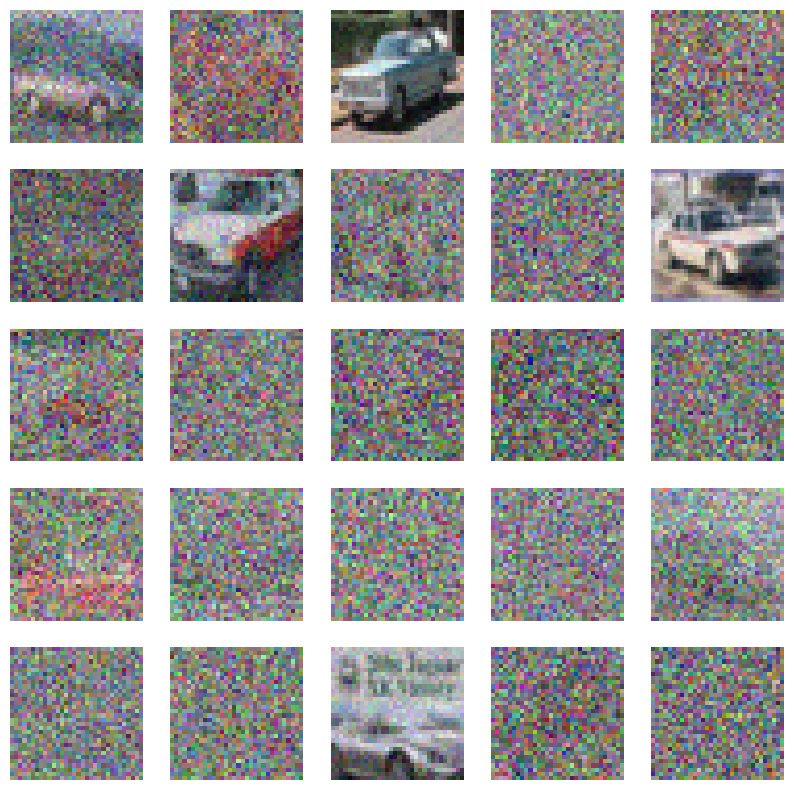

In [5]:
def forward_noise(x,t): #to move from clear to noise
    a=time_bar[t] #noise image
    b=time_bar[t+1] #clear image
    noise=np.random.normal(size=x.shape) #noise_mask
    a=a.reshape((-1,1,1,1))
    b=b.reshape((-1,1,1,1))
    img_a=x*(1-a)+noise*a
    img_b=x*(1-b)+noise*b
    return img_a,img_b
def generate_ts(num):
    return np.random.randint(0,timesteps,size=num)

t=generate_ts(25)
a,b=forward_noise(x_train[:25],t)
show_examples(a)

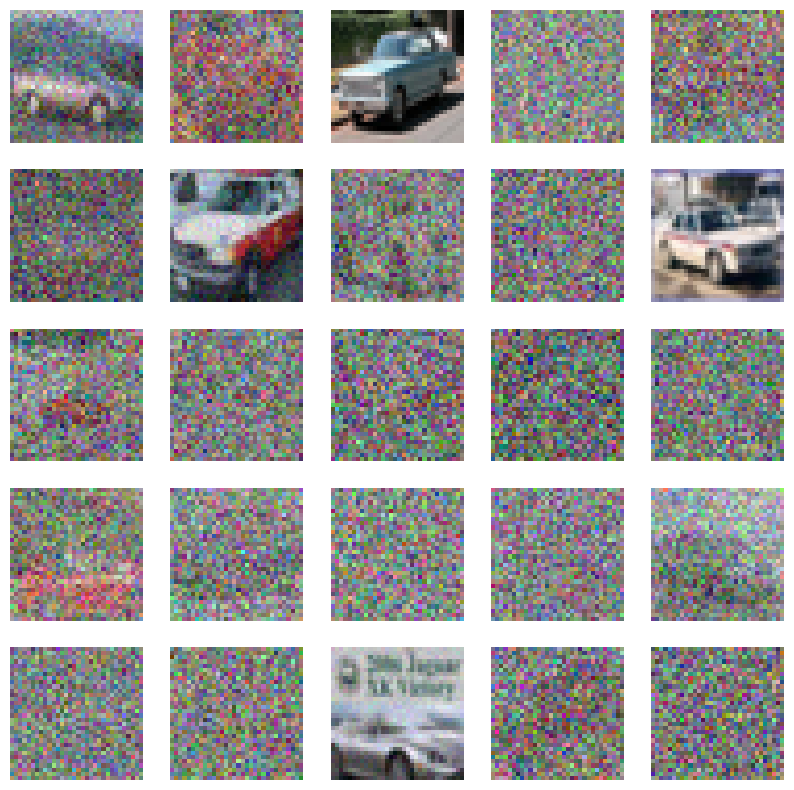

In [6]:
show_examples(b)

In [7]:
def block(x_img,x_ts):
    x_parameter=layers.Conv2D(128,kernel_size=3,padding="same")(x_img) #to get information from image
    x_parameter=layers.Activation('relu')(x_parameter) #to make information not linear
    time_parameter =layers.Dense(128)(x_ts)
    time_parameter =layers.Activation('relu')(time_parameter)
    time_parameter =layers.Reshape((1,1,128))(time_parameter)
    x_parameter=x_parameter*time_parameter  #multipli information with time information to make image fit with time
    x_out=layers.Conv2D(128,kernel_size=3,padding="same")(x_img)
    x_out=x_out*x_parameter
    x_out=layers.LayerNormalization()(x_out)
    x_out=layers.Activation('relu')(x_out)
    return x_out
        
    

In [8]:
def make_model():
    x=x_input=layers.Input(shape=(input_image,input_image,3),name='x_input')
    x_ts=x_ts_input=layers.Input(shape=(1,),name='x_ts_input')
    x_ts=layers.Dense(192)(x_ts)
    x_ts=layers.LayerNormalization()(x_ts)
    x_ts=layers.Activation('relu')(x_ts)
    #left
    x=x32=block(x,x_ts)
    x=layers.MaxPool2D(2)(x)
    x=x16=block(x,x_ts)
    x=layers.MaxPool2D(2)(x)
    x=x8=block(x,x_ts)
    x=layers.MaxPool2D(2)(x)
    x=x4=block(x,x_ts)
    #MLP 
    x=layers.Flatten()(x)
    x=layers.Concatenate()([x,x_ts])
    x=layers.Dense(128)(x)
    x=layers.LayerNormalization()(x)
    x=layers.Activation('relu')(x)
    x=layers.Dense(4*4*32)(x)
    x=layers.LayerNormalization()(x)
    x=layers.Activation('relu')(x)
    x=layers.Reshape((4,4,32))(x)
    #right 
    x=layers.Concatenate()([x,x4])
    x=block(x,x_ts)
    x=layers.UpSampling2D(2)(x)
    x=layers.Concatenate()([x,x8])
    x=block(x,x_ts)
    x=layers.UpSampling2D(2)(x)
    x=layers.Concatenate()([x,x16])
    x=block(x,x_ts)
    x=layers.UpSampling2D(2)(x)
    x=layers.Concatenate()([x,x32])
    x=block(x,x_ts)
    x=layers.Conv2D(3,kernel_size=1,padding='same')(x)
    model=tf.keras.models.Model([x_input,x_ts_input],x)
    return model
model=make_model()   
model.summary()
    

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ x_ts_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 192)               │             384 │ x_ts_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 192)               │             384 │ dense[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 192)               │               0 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ x_input (InputLayer)          │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │          24,704 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 32, 32, 128)       │           3,584 │ x_input[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 128)               │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 32, 32, 128)       │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 1, 128)         │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 32, 32, 128)       │           3,584 │ x_input[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply (Multiply)           │ (None, 32, 32, 128)       │               0 │ activation_1[0][0],        │
│                               │                           │                 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_1 (Multiply)         │ (None, 32, 32, 128)       │               0 │ conv2d_1[0][0],            │
│                               │                           │                 │ multiply[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 32, 32, 128)       │             256 │ multiply_1[0][0]           │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 32, 32, 128)       │               0 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 3,586,819 (13.68 MB)

 Trainable params: 3,586,819 (13.68 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
m=model.compile(loss=loss_func, optimizer=optimizer)

  0%|          | 0/16 [00:00<?, ?it/s]

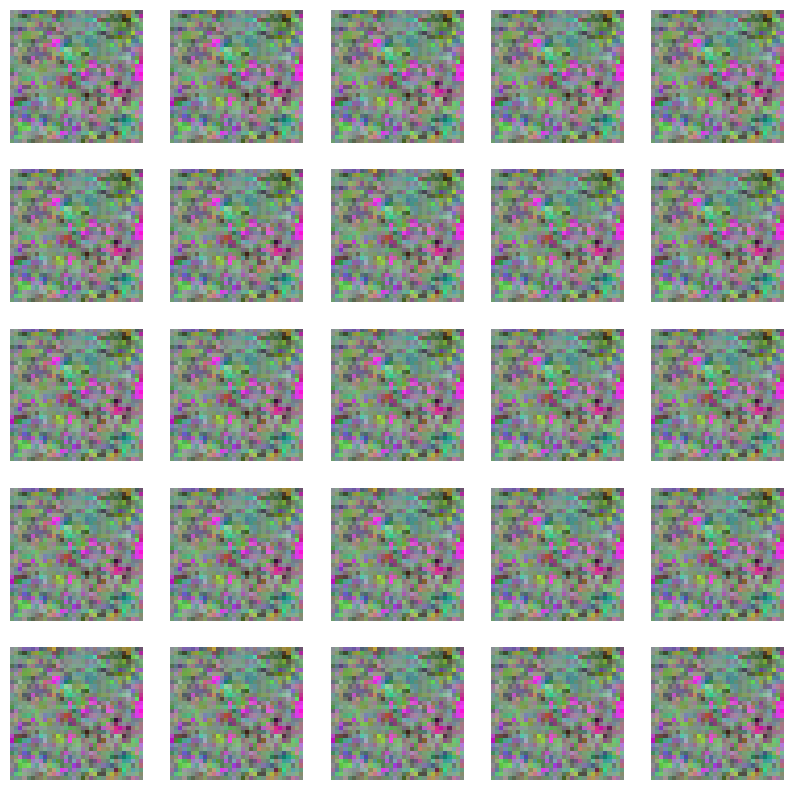

In [10]:
def predict(x_idx=None):
    x = np.random.normal(size=(32, input_image, input_image, 3))
    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((32), t)], verbose=0)
    show_examples(x)

predict()

In [11]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss

In [12]:
def train(R=50):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = x_train[np.random.randint(len(x_train), size=batch_size)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

In [ ]:
for epoch in range(10):
    train()
    
    # Reduce learning rate for next training
    new_lr = max(0.000001, model.optimizer.learning_rate * 0.9)
    model.optimizer.learning_rate = new_lr

    # Show results at certain intervals
    if epoch % 2 == 0:  # Show results every 2 epochs
        predict()
        predict_step()
        plt.pause(0.1)  # Brief pause to update plots

plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]